# **Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
import warnings
import re
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.pipeline import Pipeline
import shap

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [ ]:
# Import Google Drive to access files stored in Google Drive account
from google.colab import drive

In [ ]:
# Mount Google Drive to access the files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading the data
data = pd.read_csv('/content/drive/MyDrive/Phishing_URL_Detection/phishing.csv')
data.head()

,Index,UsingIP,LongURL,ShortURL,Symbol@,Redirecting//,PrefixSuffix-,SubDomains,HTTPS,DomainRegLen,...,UsingPopupWindow,IframeRedirection,AgeofDomain,DNSRecording,WebsiteTraffic,PageRank,GoogleIndex,LinksPointingToPage,StatsReport,class
0,0,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
1,1,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
2,2,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
3,3,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1
4,4,-1,0,-1,1,-1,-1,1,1,-1,...,1,1,1,1,1,-1,1,-1,-1,1


In [ ]:
data.shape

(11054, 32)

In [ ]:
data.columns

Index(['Index', 'UsingIP', 'LongURL', 'ShortURL', 'Symbol@', 'Redirecting//',
       'PrefixSuffix-', 'SubDomains', 'HTTPS', 'DomainRegLen', 'Favicon',
       'NonStdPort', 'HTTPSDomainURL', 'RequestURL', 'AnchorURL',
       'LinksInScriptTags', 'ServerFormHandler', 'InfoEmail', 'AbnormalURL',
       'WebsiteForwarding', 'StatusBarCust', 'DisableRightClick',
       'UsingPopupWindow', 'IframeRedirection', 'AgeofDomain', 'DNSRecording',
       'WebsiteTraffic', 'PageRank', 'GoogleIndex', 'LinksPointingToPage',
       'StatsReport', 'class'],
      dtype='object')

In [ ]:
len(data.columns)

32

In [ ]:
data.isnull().sum()

,0
Index,0
UsingIP,0
LongURL,0
ShortURL,0
Symbol@,0
Redirecting//,0
PrefixSuffix-,0
SubDomains,0
HTTPS,0
DomainRegLen,0


#**Input**

In [ ]:
X = data.drop(["class","Index"],axis=1)
y = data["class"]

# **Correlation Analysis**

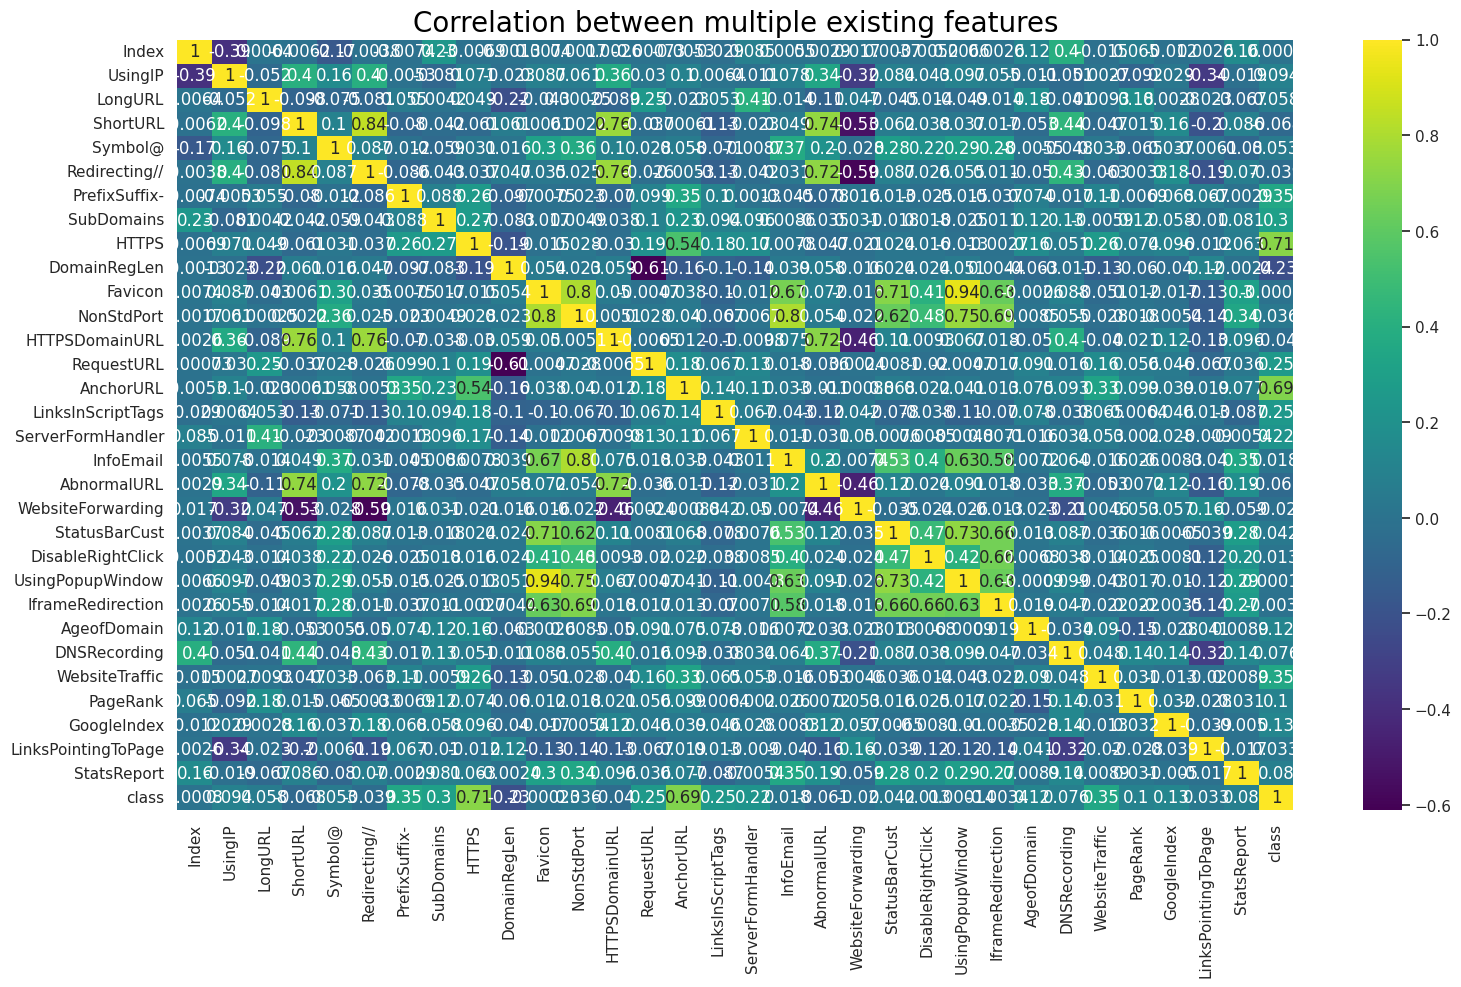

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10))
sns.heatmap(data.corr(), annot=True,cmap='viridis')
plt.title('Correlation between multiple existing features', fontsize = 20, c='black')
plt.show()


In [ ]:
corr=data.corr()
corr.head()

,Index,UsingIP,LongURL,ShortURL,Symbol@,Redirecting//,PrefixSuffix-,SubDomains,HTTPS,DomainRegLen,...,UsingPopupWindow,IframeRedirection,AgeofDomain,DNSRecording,WebsiteTraffic,PageRank,GoogleIndex,LinksPointingToPage,StatsReport,class
Index,1.000000,-0.388620,0.006441,-0.006221,-0.169437,-0.003771,-0.007402,0.233936,-0.006899,-0.001290,...,0.006593,0.002583,0.115175,0.400751,-0.015147,0.065034,-0.012466,0.002623,0.163479,0.000802
UsingIP,-0.388620,1.000000,-0.052159,0.403547,0.158766,0.397220,-0.005306,-0.080921,0.071255,-0.022830,...,0.096953,0.054739,-0.010580,-0.050929,0.002728,-0.091857,0.029206,-0.338971,-0.019420,0.094033
LongURL,0.006441,-0.052159,1.000000,-0.097976,-0.075205,-0.080788,0.055334,0.004249,0.049033,-0.221807,...,-0.049486,-0.013902,0.179678,-0.040549,0.009296,0.183672,0.002825,-0.023216,-0.066708,0.057661
ShortURL,-0.006221,0.403547,-0.097976,1.000000,0.104433,0.843149,-0.080458,-0.041874,-0.061383,0.060950,...,0.036599,0.016570,-0.052562,0.436163,-0.047025,0.014612,0.155832,-0.198463,0.085572,-0.067931
Symbol@,-0.169437,0.158766,-0.075205,0.104433,1.000000,0.087086,-0.011711,-0.058931,0.031275,0.015549,...,0.290880,0.284401,-0.005459,-0.047820,0.032981,-0.064714,0.037047,-0.006124,-0.080286,0.052994


In [ ]:
corr['class']=abs(corr['class'])
corr.head()

,Index,UsingIP,LongURL,ShortURL,Symbol@,Redirecting//,PrefixSuffix-,SubDomains,HTTPS,DomainRegLen,...,UsingPopupWindow,IframeRedirection,AgeofDomain,DNSRecording,WebsiteTraffic,PageRank,GoogleIndex,LinksPointingToPage,StatsReport,class
Index,1.000000,-0.388620,0.006441,-0.006221,-0.169437,-0.003771,-0.007402,0.233936,-0.006899,-0.001290,...,0.006593,0.002583,0.115175,0.400751,-0.015147,0.065034,-0.012466,0.002623,0.163479,0.000802
UsingIP,-0.388620,1.000000,-0.052159,0.403547,0.158766,0.397220,-0.005306,-0.080921,0.071255,-0.022830,...,0.096953,0.054739,-0.010580,-0.050929,0.002728,-0.091857,0.029206,-0.338971,-0.019420,0.094033
LongURL,0.006441,-0.052159,1.000000,-0.097976,-0.075205,-0.080788,0.055334,0.004249,0.049033,-0.221807,...,-0.049486,-0.013902,0.179678,-0.040549,0.009296,0.183672,0.002825,-0.023216,-0.066708,0.057661
ShortURL,-0.006221,0.403547,-0.097976,1.000000,0.104433,0.843149,-0.080458,-0.041874,-0.061383,0.060950,...,0.036599,0.016570,-0.052562,0.436163,-0.047025,0.014612,0.155832,-0.198463,0.085572,0.067931
Symbol@,-0.169437,0.158766,-0.075205,0.104433,1.000000,0.087086,-0.011711,-0.058931,0.031275,0.015549,...,0.290880,0.284401,-0.005459,-0.047820,0.032981,-0.064714,0.037047,-0.006124,-0.080286,0.052994


In [ ]:
incCorr=corr.sort_values(by='class', ascending=False)
incCorr.head()

,Index,UsingIP,LongURL,ShortURL,Symbol@,Redirecting//,PrefixSuffix-,SubDomains,HTTPS,DomainRegLen,...,UsingPopupWindow,IframeRedirection,AgeofDomain,DNSRecording,WebsiteTraffic,PageRank,GoogleIndex,LinksPointingToPage,StatsReport,class
class,0.000802,0.094033,0.057661,-0.067931,0.052994,-0.038885,0.348588,0.298231,0.714704,-0.225879,...,0.000136,-0.003362,0.121402,0.075579,0.346003,0.104593,0.129000,0.032694,0.079632,1.000000
HTTPS,-0.006899,0.071255,0.049033,-0.061383,0.031275,-0.036536,0.261366,0.267531,1.000000,-0.193730,...,-0.012945,-0.002734,0.162700,0.050797,0.258625,0.074479,0.096110,-0.011569,0.063126,0.714704
AnchorURL,-0.005275,0.099701,-0.023153,0.000607,0.057968,-0.005341,0.348854,0.229374,0.535712,-0.160355,...,0.041211,0.013441,0.075393,0.093131,0.326172,0.099201,0.038866,0.018788,0.077115,0.692895
PrefixSuffix-,-0.007402,-0.005306,0.055334,-0.080458,-0.011711,-0.085709,1.000000,0.087852,0.261366,-0.096826,...,-0.014716,-0.036894,0.074083,-0.016610,0.110555,-0.006855,0.067796,0.067469,-0.002851,0.348588
WebsiteTraffic,-0.015147,0.002728,0.009296,-0.047025,0.032981,-0.062761,0.110555,-0.005948,0.258625,-0.134571,...,-0.043126,-0.022037,0.089814,0.048450,1.000000,0.030905,-0.012529,-0.019701,0.008878,0.346003


In [ ]:
# Decreasing order of Columns with respect to correlation
incCorr['class']

,class
class,1.000000
HTTPS,0.714704
AnchorURL,0.692895
PrefixSuffix-,0.348588
WebsiteTraffic,0.346003
SubDomains,0.298231
RequestURL,0.253478
LinksInScriptTags,0.248415
DomainRegLen,0.225879
ServerFormHandler,0.221380


In [ ]:
# Selection Top N features with respect to correlation
tenfeatures=incCorr[1:11].index
twenfeatures=incCorr[1:21].index

In [ ]:
# Structutre to Store the metrics
ML_Model = []
accuracy = []
f1_score = []
precision = []
recall_score = []

def storeResults(model, a,b,c,d):
  ML_Model.append(model)
  accuracy.append(round(a, 3))
  f1_score.append(round(b, 3))
  precision.append(round(c, 3))
  recall_score.append(round(d,3))

# **K-Nearest Neighbors (Lazy Learning Algorithm)**

In [ ]:
# Finding Optimal Value of K

def KNN(X):
  x=[a for a in range(1,10,2)]
  knntrain=[]
  knntest=[]

  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
  X_train.shape, y_train.shape, X_test.shape, y_test.shape

  for i in range(1,10,2):
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    y_train_knn = knn.predict(X_train)
    y_test_knn = knn.predict(X_test)
    acc_train_knn = metrics.accuracy_score(y_train,y_train_knn)
    acc_test_knn = metrics.accuracy_score(y_test,y_test_knn)
    print("K-Nearest Neighbors with k={}: Accuracy on training Data: {:.3f}".format(i,acc_train_knn))
    print("K-Nearest Neighbors with k={}: Accuracy on test Data: {:.3f}".format(i,acc_test_knn))
    knntrain.append(acc_train_knn)
    knntest.append(acc_test_knn)
    print()

  import matplotlib.pyplot as plt
  plt.plot(x,knntrain,label="Train accuracy")
  plt.plot(x,knntest,label="Test accuracy")
  plt.legend()
  plt.show()

K-Nearest Neighbors with k=1: Accuracy on training Data: 0.988
K-Nearest Neighbors with k=1: Accuracy on test Data: 0.959

K-Nearest Neighbors with k=3: Accuracy on training Data: 0.978
K-Nearest Neighbors with k=3: Accuracy on test Data: 0.942

K-Nearest Neighbors with k=5: Accuracy on training Data: 0.964
K-Nearest Neighbors with k=5: Accuracy on test Data: 0.940

K-Nearest Neighbors with k=7: Accuracy on training Data: 0.960
K-Nearest Neighbors with k=7: Accuracy on test Data: 0.936

K-Nearest Neighbors with k=9: Accuracy on training Data: 0.953
K-Nearest Neighbors with k=9: Accuracy on test Data: 0.941



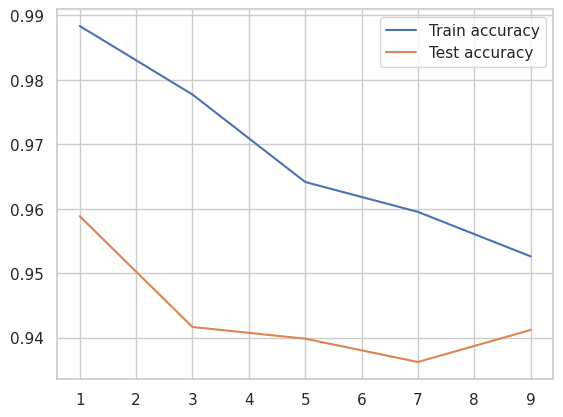

In [ ]:
Xmain=X
Xten=X[tenfeatures]
Xtwen=X[twenfeatures]

KNN(Xmain)

As the value of K increases, the model's accuracy tends to decrease. While K = 1 yields the highest accuracy on the training data, it is highly susceptible to overfitting due to its sensitivity to noise and variance. Therefore, despite the initial high accuracy, a larger K is often preferred to improve generalization and reduce overfitting.

K-Nearest Neighbors with k=1: Accuracy on training Data: 0.939
K-Nearest Neighbors with k=1: Accuracy on test Data: 0.930

K-Nearest Neighbors with k=3: Accuracy on training Data: 0.948
K-Nearest Neighbors with k=3: Accuracy on test Data: 0.935

K-Nearest Neighbors with k=5: Accuracy on training Data: 0.947
K-Nearest Neighbors with k=5: Accuracy on test Data: 0.936

K-Nearest Neighbors with k=7: Accuracy on training Data: 0.944
K-Nearest Neighbors with k=7: Accuracy on test Data: 0.934

K-Nearest Neighbors with k=9: Accuracy on training Data: 0.944
K-Nearest Neighbors with k=9: Accuracy on test Data: 0.937



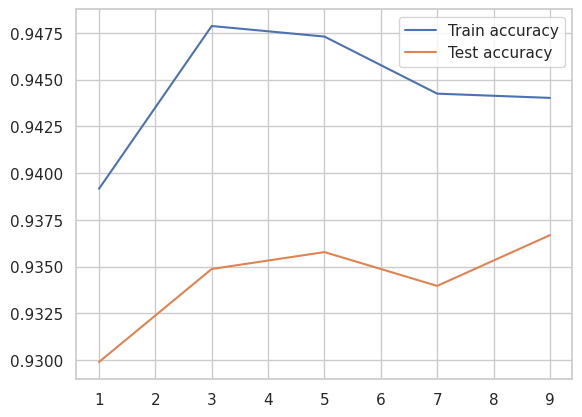

In [ ]:
# X with top ten features
KNN(Xten)

The difference between training and testing accuracy is smaller when using the reduced feature set compared to using all features. This indicates improved generalization and suggests that the model is a good fit, with reduced risk of overfitting.

K-Nearest Neighbors with k=1: Accuracy on training Data: 0.982
K-Nearest Neighbors with k=1: Accuracy on test Data: 0.951

K-Nearest Neighbors with k=3: Accuracy on training Data: 0.972
K-Nearest Neighbors with k=3: Accuracy on test Data: 0.941

K-Nearest Neighbors with k=5: Accuracy on training Data: 0.960
K-Nearest Neighbors with k=5: Accuracy on test Data: 0.943

K-Nearest Neighbors with k=7: Accuracy on training Data: 0.957
K-Nearest Neighbors with k=7: Accuracy on test Data: 0.940

K-Nearest Neighbors with k=9: Accuracy on training Data: 0.952
K-Nearest Neighbors with k=9: Accuracy on test Data: 0.943



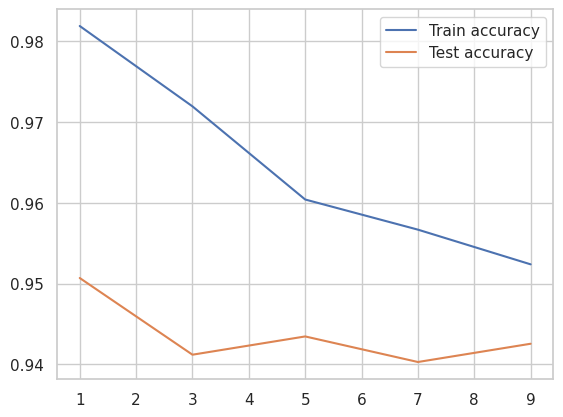

In [ ]:
# X with top twenty features
KNN(Xtwen)

As K increases, accuracy decreases. While K = 1 gives the highest accuracy, it tends to overfit due to sensitivity to noise.

***Observation:***

**K = 5 with X[top 10 features] yielded the best accuracy.** However, limiting the model to only 10 features may lead to underfitting, as it doesn’t fully utilize the available information.

***Note:***
In KNN, a smaller K can lead to overfitting, while a larger K may cause underfitting. Choosing an optimal K is crucial to balance bias and variance.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)

y_train_knn = knn.predict(X_train)
y_test_knn = knn.predict(X_test)

**Evaluation matrix for KNN Model**

**Accuracy Score**

In [ ]:
acc_test_knn = metrics.accuracy_score(y_test,y_test_knn)

In [ ]:
acc_test_knn

0.939846223428313

**F1 Score (Test Set)**

In [ ]:
f1_score_test_knn = metrics.f1_score(y_test,y_test_knn)
f1_score_test_knn

0.9463493344090359

 **AUC Score (Test Set)**

In [ ]:
from sklearn.metrics import roc_auc_score
auc_score_test_knn = roc_auc_score(y_test, y_test_knn)
auc_score_test_knn

np.float64(0.9385258346054292)

**Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
cm_knn= confusion_matrix(y_test, y_test_knn)
cm_knn

array([[ 905,   71],
       [  62, 1173]])

**ROC Score (Test Set)**

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_test_knn)
auc_value_knn = auc(fpr_knn, tpr_knn)
auc_value_knn

np.float64(0.9385258346054292)

**Precision and Recall**

In [ ]:
precision_score_test_knn = metrics.precision_score(y_test,y_test_knn)

In [ ]:
from sklearn import metrics

recall_score_knn = metrics.recall_score(y_test, y_test_knn)
recall_score_knn

0.9497975708502024

In [ ]:
storeResults('K-Nearest Neighbors',acc_test_knn,f1_score_test_knn,precision_score_test_knn,recall_score_knn)

# **Support Vector Machine (SVM)**

In [ ]:
def SVM(X, y):
    x=[a for a in range(1,10,2)]
    svmtrain=[]
    svmtest=[]

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    X_train.shape, y_train.shape, X_test.shape, y_test.shape

    from sklearn.svm import SVC
    for i in range(1,10,2):
        svm = SVC(kernel='linear', C=i)
        svm.fit(X_train, y_train)
        y_train_svm = svm.predict(X_train)
        y_test_svm = svm.predict(X_test)
        acc_train_svm = metrics.accuracy_score(y_train, y_train_svm)
        acc_test_svm = metrics.accuracy_score(y_test, y_test_svm)
        print("SVM with C={}: Accuracy on training Data: {:.3f}".format(i,acc_train_svm))
        print("SVM with C={}: Accuracy on test Data: {:.3f}".format(i,acc_test_svm))
        svmtrain.append(acc_train_svm)
        svmtest.append(acc_test_svm)
        print()

    import matplotlib.pyplot as plt
    plt.plot(x,svmtrain,label="Train accuracy")
    plt.plot(x,svmtest,label="Test accuracy")
    plt.legend()
    plt.show()

SVM with C=1: Accuracy on training Data: 0.926
SVM with C=1: Accuracy on test Data: 0.935

SVM with C=3: Accuracy on training Data: 0.926
SVM with C=3: Accuracy on test Data: 0.935

SVM with C=5: Accuracy on training Data: 0.926
SVM with C=5: Accuracy on test Data: 0.935

SVM with C=7: Accuracy on training Data: 0.926
SVM with C=7: Accuracy on test Data: 0.935

SVM with C=9: Accuracy on training Data: 0.926
SVM with C=9: Accuracy on test Data: 0.935



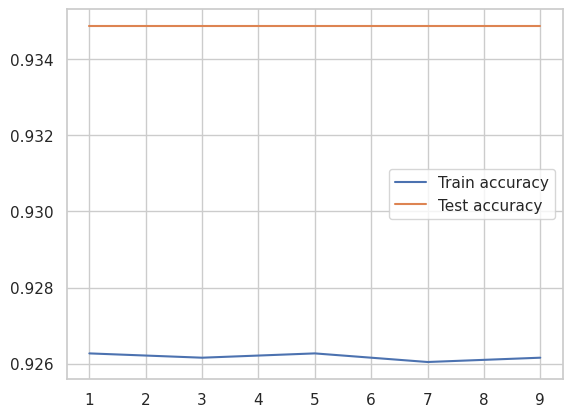

In [ ]:
Xmain=X
Xten=X[tenfeatures]
Xtwen=X[twenfeatures]

SVM(Xmain,y)

SVM with C=1: Accuracy on training Data: 0.919
SVM with C=1: Accuracy on test Data: 0.925

SVM with C=3: Accuracy on training Data: 0.919
SVM with C=3: Accuracy on test Data: 0.925

SVM with C=5: Accuracy on training Data: 0.919
SVM with C=5: Accuracy on test Data: 0.925

SVM with C=7: Accuracy on training Data: 0.919
SVM with C=7: Accuracy on test Data: 0.925

SVM with C=9: Accuracy on training Data: 0.919
SVM with C=9: Accuracy on test Data: 0.925



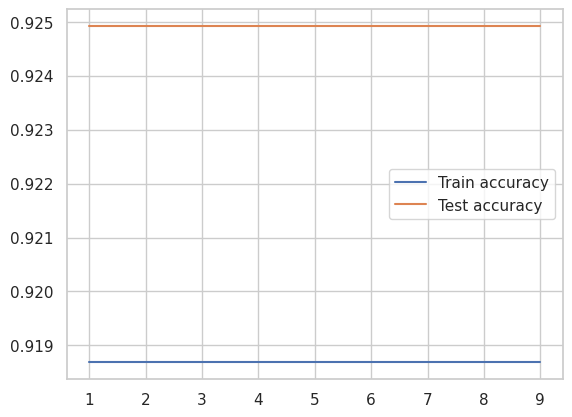

In [ ]:
SVM(Xten,y)

SVM with C=1: Accuracy on training Data: 0.920
SVM with C=1: Accuracy on test Data: 0.929

SVM with C=3: Accuracy on training Data: 0.920
SVM with C=3: Accuracy on test Data: 0.929

SVM with C=5: Accuracy on training Data: 0.920
SVM with C=5: Accuracy on test Data: 0.929

SVM with C=7: Accuracy on training Data: 0.920
SVM with C=7: Accuracy on test Data: 0.929

SVM with C=9: Accuracy on training Data: 0.920
SVM with C=9: Accuracy on test Data: 0.929



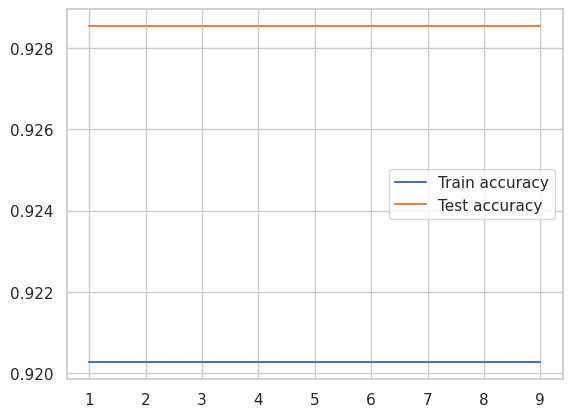

In [ ]:
SVM(Xtwen,y)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm = SVC(kernel='linear', C=1, random_state=42)
svm.fit(X_train, y_train)

y_train_svm = svm.predict(X_train)
y_test_svm = svm.predict(X_test)

**Evalution Matrix for SVM**

In [ ]:
# Accuracy score
acc_test_svm = metrics.accuracy_score(y_test, y_test_svm)
print(f"Accuracy Score (SVM): {acc_test_svm:.4f}")

# f1 score
f1_score_test_svm = metrics.f1_score(y_test, y_test_svm)
print(f"F1 Score (SVM): {f1_score_test_svm:.4f}")

# AUC score
from sklearn.metrics import roc_auc_score
auc_score_test_svm = roc_auc_score(y_test, y_test_svm)
print(f"AUC Score (SVM): {auc_score_test_svm:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_svm = confusion_matrix(y_test, y_test_svm)
print("Confusion Matrix (SVM):")
print(cm_svm)

# ROC curve
from sklearn.metrics import roc_curve, auc
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_test_svm)
auc_value_svm = auc(fpr_svm, tpr_svm)
auc_value_svm
print(f"ROC Score (SVM): {auc_score_test_svm:.4f}")

# Precision
precision_score_test_svm = metrics.precision_score(y_test,y_test_svm)

# Recall
from sklearn import metrics
recall_score_svm = metrics.recall_score(y_test, y_test_svm)
print(f"Recall Score (SVM): {recall_score_svm:.4f}")

Accuracy Score (SVM): 0.9349
F1 Score (SVM): 0.9425
AUC Score (SVM): 0.9321
Confusion Matrix (SVM):
[[ 887   89]
 [  55 1180]]
ROC Score (SVM): 0.9321
Recall Score (SVM): 0.9555


In [ ]:
storeResults('Support Vector Machines',acc_test_svm,f1_score_test_svm,precision_score_test_svm,recall_score_svm)

# **Gradient Boosting Classifier**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8843, 30), (8843,), (2211, 30), (2211,))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(max_depth=4,learning_rate=0.7)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.7, max_depth=4)

In [ ]:
y_train_gbc = gbc.predict(X_train)
y_test_gbc = gbc.predict(X_test)

**Evalution Matrix for Gradient Boosting**

In [ ]:
# Accuracy score
acc_test_gbc = metrics.accuracy_score(y_test, y_test_gbc)
print(f"Accuracy Score (GB): {acc_test_gbc:.4f}")

# f1 score
f1_score_test_gbc = metrics.f1_score(y_test, y_test_gbc)
print(f"F1 Score (GB): {f1_score_test_gbc:.4f}")

# AUC score
from sklearn.metrics import roc_auc_score
auc_score_test_gbc = roc_auc_score(y_test, y_test_gbc)
print(f"AUC Score (GB): {auc_score_test_gbc:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_gbc = confusion_matrix(y_test, y_test_gbc)
print("Confusion Matrix (GB):")
print(cm_gbc)

# ROC curve
from sklearn.metrics import roc_curve, auc
fpr_gbc, tpr_gbc, thresholds_gbc = roc_curve(y_test, y_test_gbc)
auc_value_gbc = auc(fpr_gbc, tpr_gbc)
print(f"ROC Score (GB): {auc_value_gbc:.4f}")

# Precision
precision_score_test_gbc = metrics.precision_score(y_test,y_test_gbc)

# Recall
from sklearn import metrics
recall_score_gbc = metrics.recall_score(y_test, y_test_gbc)
print(f"Recall Score (GB): {recall_score_gbc:.4f}")

Accuracy Score (GB): 0.9742
F1 Score (GB): 0.9772
AUC Score (GB): 0.9723
Confusion Matrix (GB):
[[ 933   43]
 [  14 1221]]
ROC Score (GB): 0.9723
Recall Score (GB): 0.9887


In [ ]:
storeResults('Gradient Boosting Classifier',acc_test_gbc,f1_score_test_gbc,precision_score_test_gbc,recall_score_gbc)

# **Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier
rfc = RandomForestClassifier(max_depth=4, random_state=42)

# Fit the model on the training data
rfc.fit(X_train, y_train)

# Predictions on training and testing sets
y_train_rfc = rfc.predict(X_train)
y_test_rfc = rfc.predict(X_test)

**Evalution Matrix for Random Forest Classifier**

In [ ]:
# Accuracy score
acc_test_rfc = metrics.accuracy_score(y_test, y_test_rfc)
print(f"Accuracy Score (RF): {acc_test_rfc:.4f}")

# f1 score
f1_score_test_rfc = metrics.f1_score(y_test, y_test_rfc)
print(f"F1 Score (RF): {f1_score_test_rfc:.4f}")

# AUC score
from sklearn.metrics import roc_auc_score
auc_score_test_rfc = roc_auc_score(y_test, y_test_rfc)
print(f"AUC Score (RF): {auc_score_test_rfc:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_rfc = confusion_matrix(y_test, y_test_rfc)
print("Confusion Matrix (RF):")
print(cm_rfc)

# ROC curve
from sklearn.metrics import roc_curve, auc
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, y_test_rfc)
auc_value_rfc = auc(fpr_rfc, tpr_rfc)
print(f"ROC Score (RF): {auc_value_rfc:.4f}")

# Precision
precision_score_test_rfc = metrics.precision_score(y_test,y_test_rfc)

# Recall
from sklearn import metrics
recall_score_rfc = metrics.recall_score(y_test, y_test_rfc)
print(f"Recall Score (RF): {recall_score_rfc:.4f}")

Accuracy Score (RF): 0.9322
F1 Score (RF): 0.9403
AUC Score (RF): 0.9290
Confusion Matrix (RF):
[[ 880   96]
 [  54 1181]]
ROC Score (RF): 0.9290
Recall Score (RF): 0.9563


In [ ]:
storeResults('Random Forest Classifier',acc_test_rfc,f1_score_test_rfc,precision_score_test_rfc,recall_score_rfc)

# **Decission Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create a DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=4, random_state=42)

# Fit the model on the training data
dtc.fit(X_train, y_train)

# Predictions on training and testing sets
y_train_dtc = dtc.predict(X_train)
y_test_dtc = dtc.predict(X_test)

**Evalution Matrix for Decission Tree Classifier**

In [ ]:
# Accuracy score
acc_test_dtc = metrics.accuracy_score(y_test, y_test_dtc)
print(f"Accuracy Score (DT): {acc_test_dtc:.4f}")

# f1 score
f1_score_test_dtc = metrics.f1_score(y_test, y_test_dtc)
print(f"F1 Score (DT): {f1_score_test_dtc:.4f}")

# AUC score
from sklearn.metrics import roc_auc_score
auc_score_test_dtc = roc_auc_score(y_test, y_test_dtc)
print(f"AUC Score (DT): {auc_score_test_dtc:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_dtc = confusion_matrix(y_test, y_test_dtc)
print("Confusion Matrix (DT):")
print(cm_dtc)

# ROC curve
from sklearn.metrics import roc_curve, auc
fpr_dtc, tpr_dtc, thresholds_dtc = roc_curve(y_test, y_test_dtc)
auc_value_dtc = auc(fpr_rfc, tpr_dtc)
print(f"ROC Score (DT): {auc_value_dtc:.4f}")

# Precision
precision_score_test_dtc = metrics.precision_score(y_test,y_test_dtc)

# Recall
from sklearn import metrics
recall_score_dtc = metrics.recall_score(y_test, y_test_dtc)
print(f"Recall Score (DT): {recall_score_dtc:.4f}")

Accuracy Score (DT): 0.9231
F1 Score (DT): 0.9312
AUC Score (DT): 0.9220
Confusion Matrix (DT):
[[ 891   85]
 [  85 1150]]
ROC Score (DT): 0.9164
Recall Score (DT): 0.9312


In [ ]:
storeResults('Decission Tree Classifier',acc_test_dtc,f1_score_test_dtc,precision_score_test_dtc,recall_score_dtc)

# **Comparision of all Model scores**

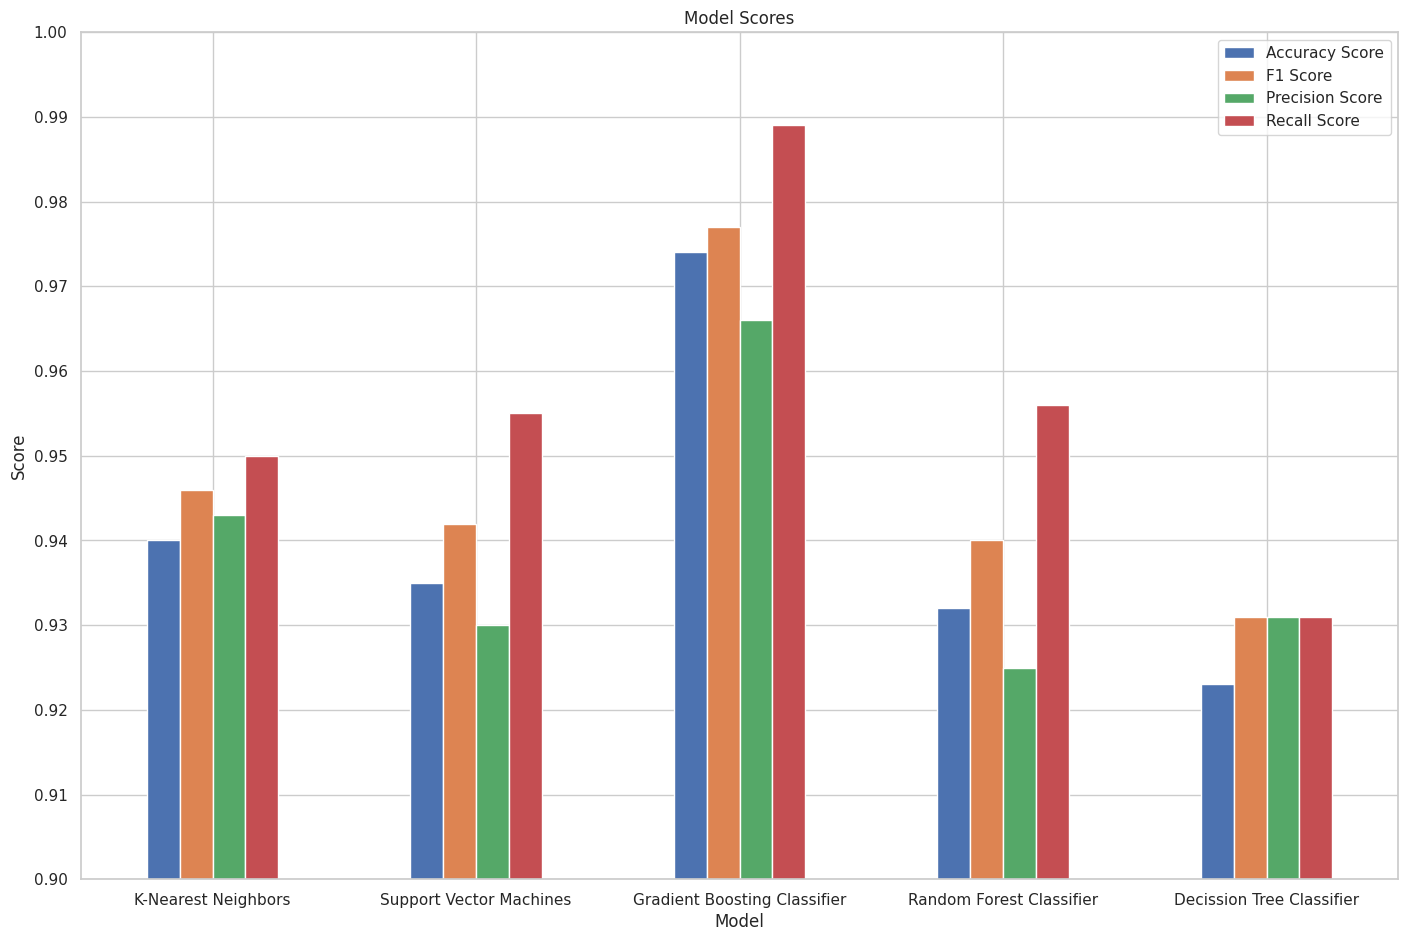

In [ ]:
df = pd.DataFrame({
    'Modelname': ML_Model,
    'Accuracy Score': accuracy,
    'F1 Score': f1_score,
    'Precision Score': precision,
    'Recall Score':recall_score
})
df.set_index('Modelname', inplace=True)

# Plot the scores for each model
fig, ax = plt.subplots(figsize=(17,11))
df.plot(kind='bar', ax=ax)
ax.set_xticklabels(df.index, rotation=0)
ax.set_ylim([0.9, 1])
ax.set_yticks([0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1])
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Scores')
plt.show()

# **Confusion Matrix for all models**

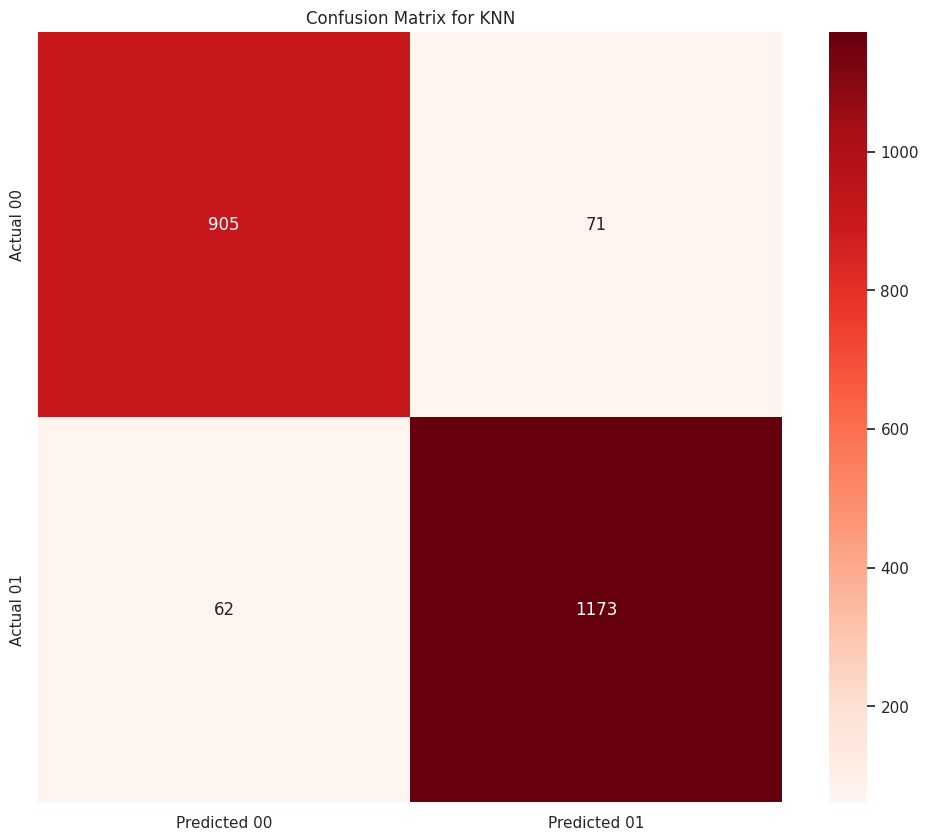

In [ ]:
# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Reds", xticklabels=["Predicted 00", "Predicted 01"], yticklabels=["Actual 00", "Actual 01"])
plt.title('Confusion Matrix for KNN')
plt.show()

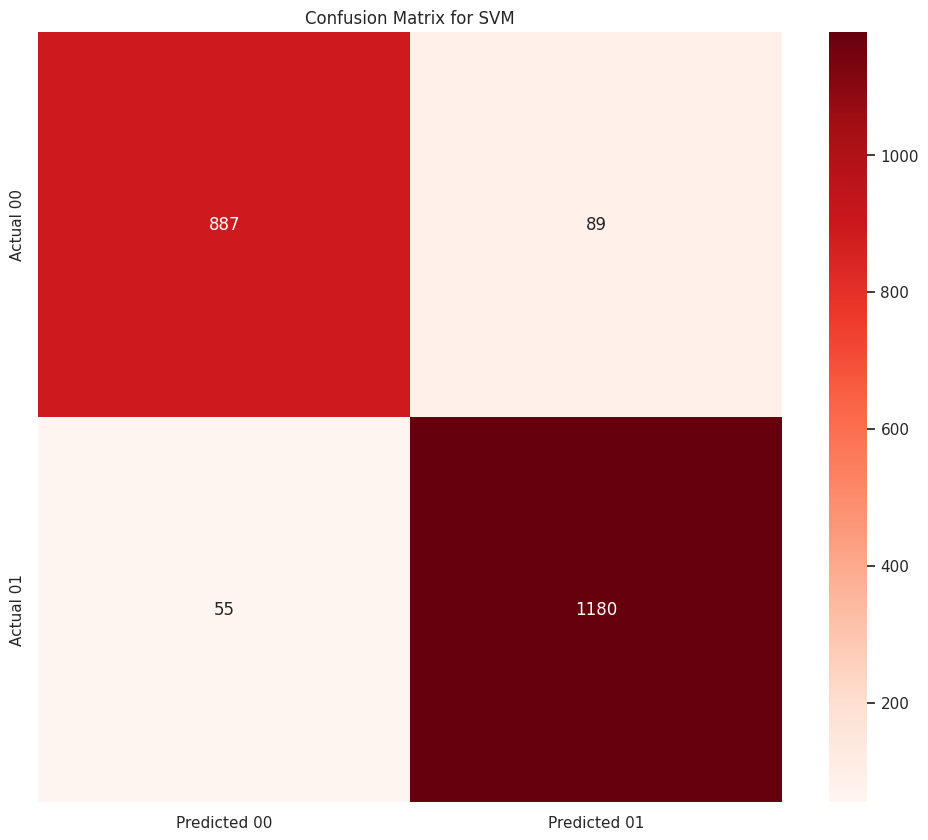

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Reds", xticklabels=["Predicted 00", "Predicted 01"], yticklabels=["Actual 00", "Actual 01"])
plt.title('Confusion Matrix for SVM')
plt.show()

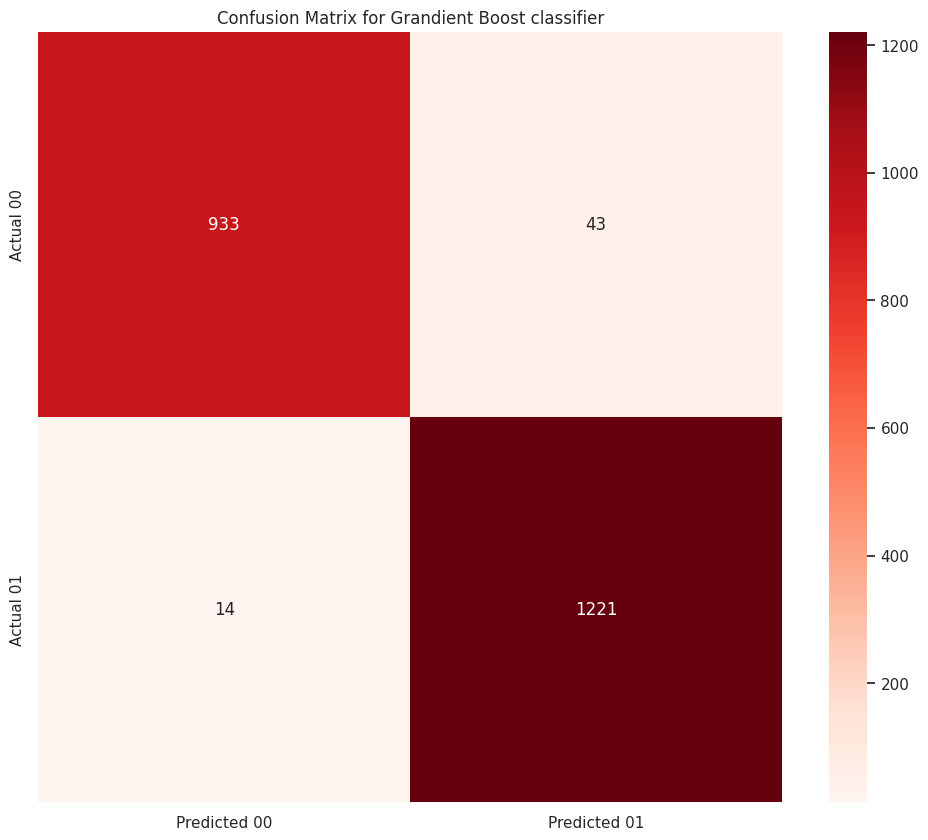

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm_gbc, annot=True, fmt="d", cmap="Reds", xticklabels=["Predicted 00", "Predicted 01"], yticklabels=["Actual 00", "Actual 01"])
plt.title('Confusion Matrix for Grandient Boost classifier')
plt.show()

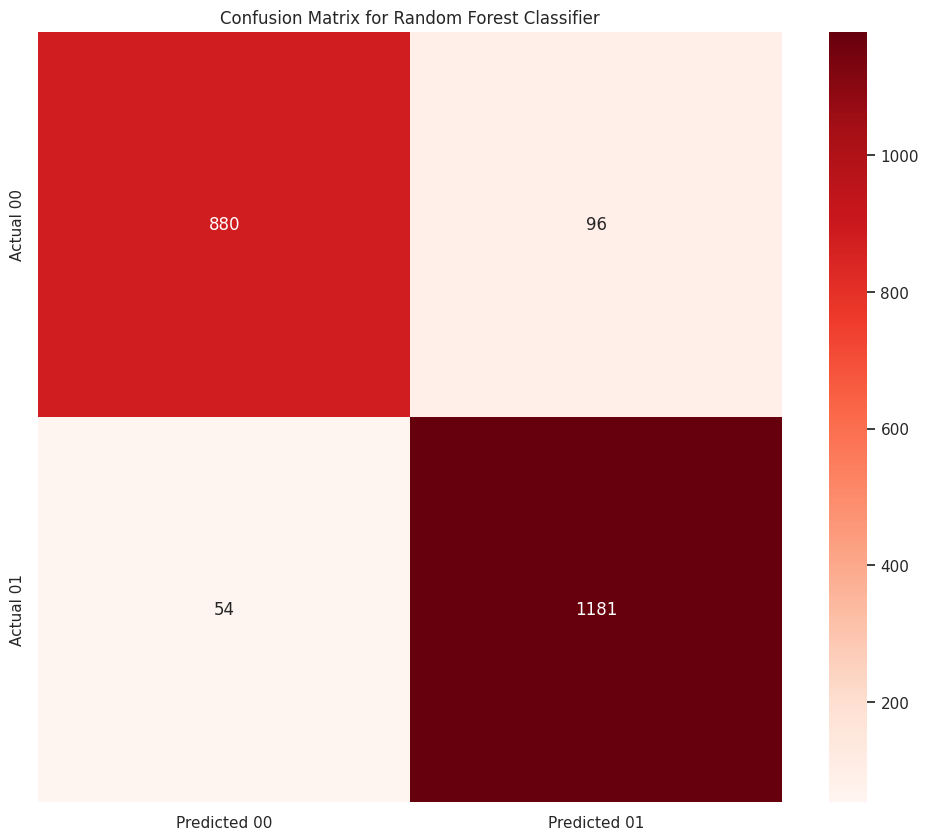

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm_rfc, annot=True, fmt="d", cmap="Reds", xticklabels=["Predicted 00", "Predicted 01"], yticklabels=["Actual 00", "Actual 01"])
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

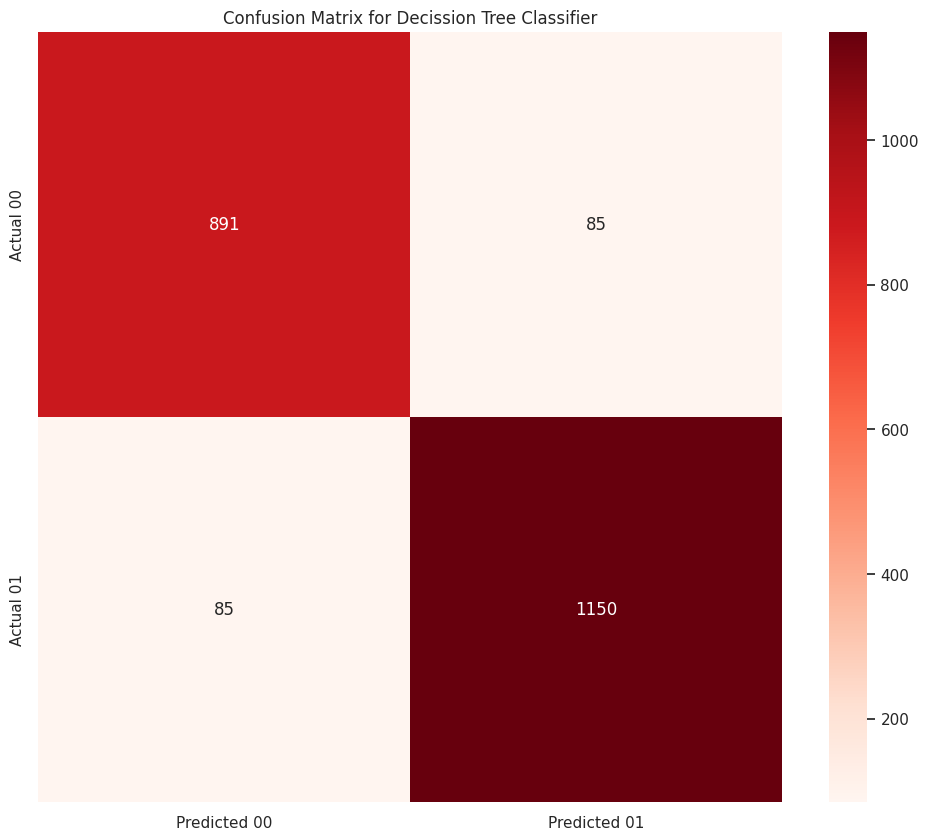

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm_dtc, annot=True, fmt="d", cmap="Reds", xticklabels=["Predicted 00", "Predicted 01"], yticklabels=["Actual 00", "Actual 01"])
plt.title('Confusion Matrix for Decission Tree Classifier')
plt.show()

# **ROC Curve for all Models**

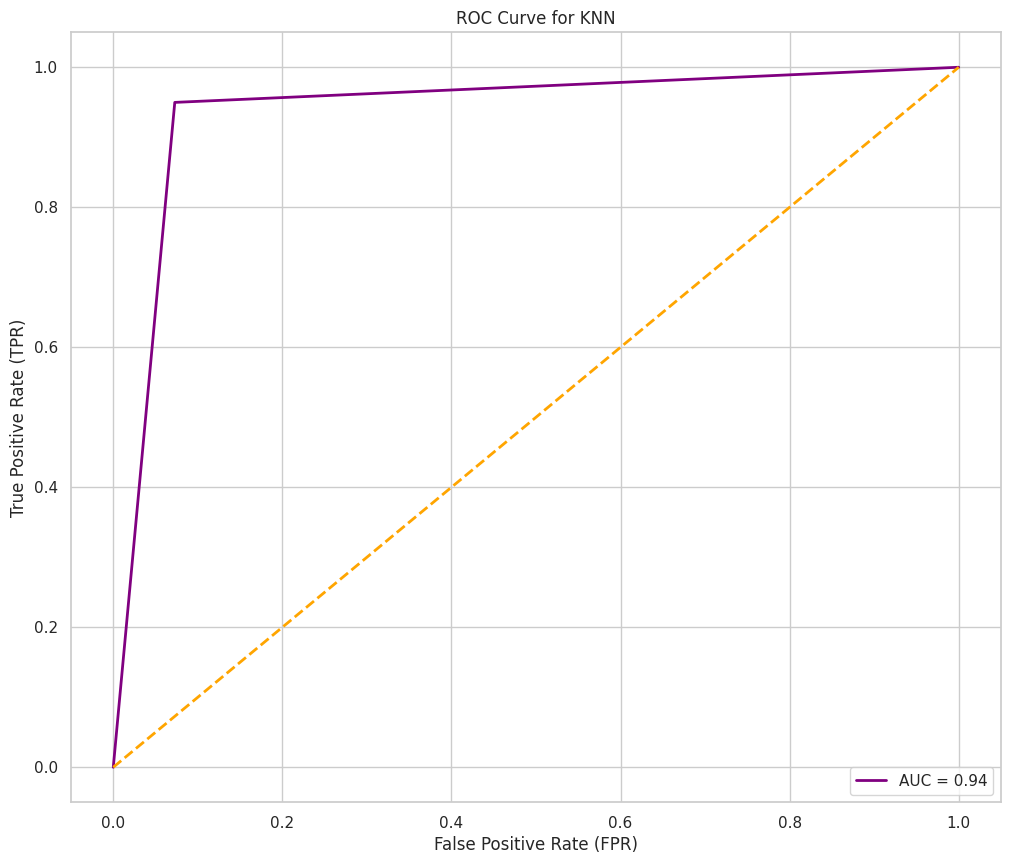

In [ ]:
plt.figure(figsize=(12, 10))
plt.plot(fpr_knn, tpr_knn, color='purple', lw=2, label=f'AUC = {auc_value_knn:.2f}')
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for KNN')
plt.legend(loc='lower right')
plt.show()

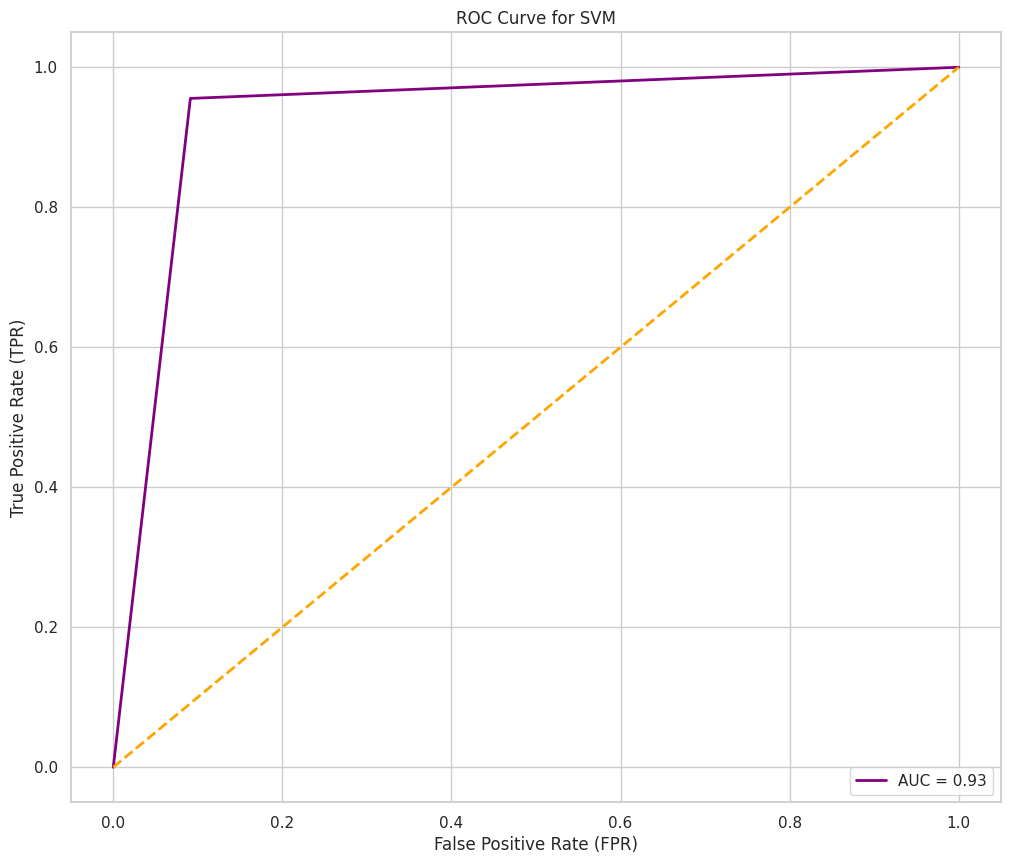

In [ ]:
plt.figure(figsize=(12, 10))
plt.plot(fpr_svm, tpr_svm, color='purple', lw=2, label=f'AUC = {auc_value_svm:.2f}')
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for SVM')
plt.legend(loc='lower right')
plt.show()

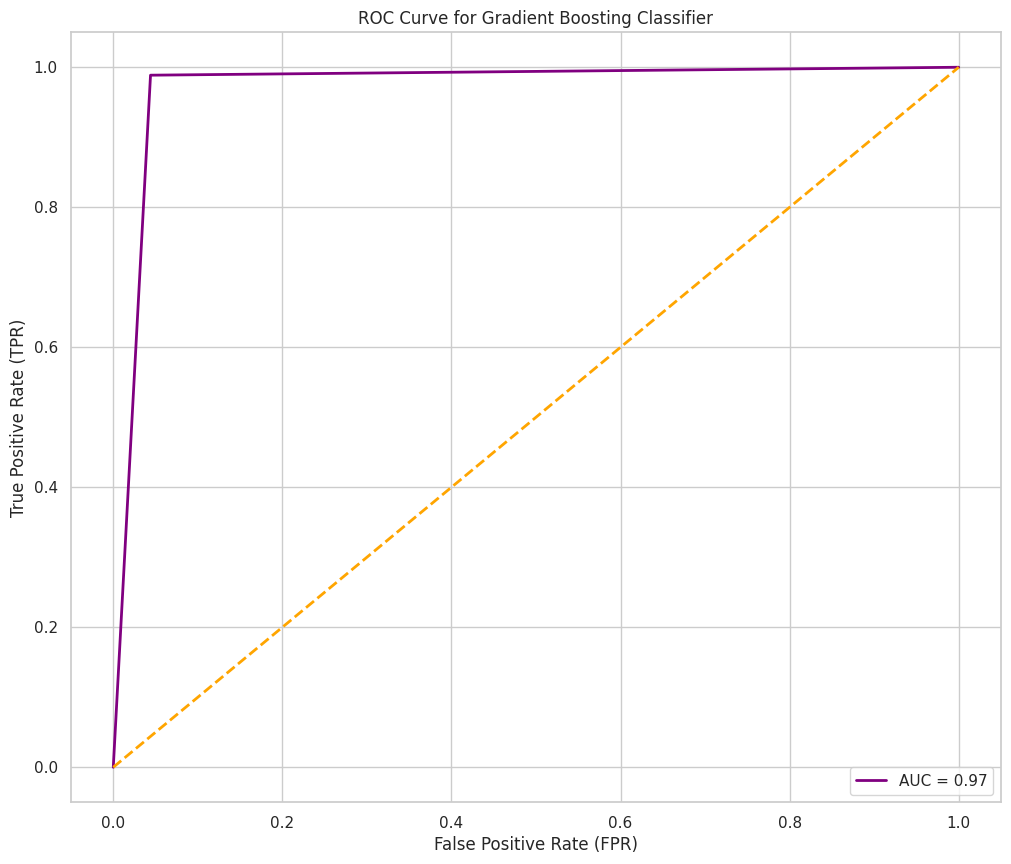

In [ ]:
plt.figure(figsize=(12, 10))
plt.plot(fpr_gbc, tpr_gbc, color='purple', lw=2, label=f'AUC = {auc_value_gbc:.2f}')
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Gradient Boosting Classifier')
plt.legend(loc='lower right')
plt.show()

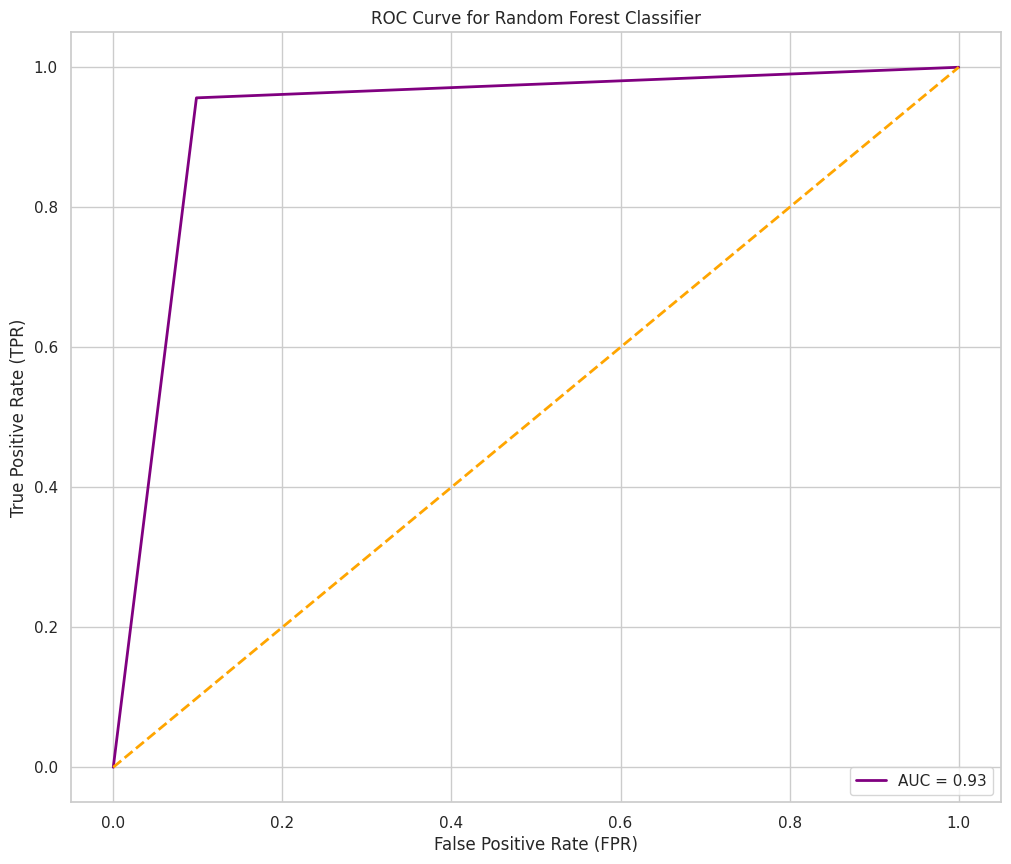

In [ ]:
plt.figure(figsize=(12, 10))
plt.plot(fpr_rfc, tpr_rfc, color='purple', lw=2, label=f'AUC = {auc_value_rfc:.2f}')
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()

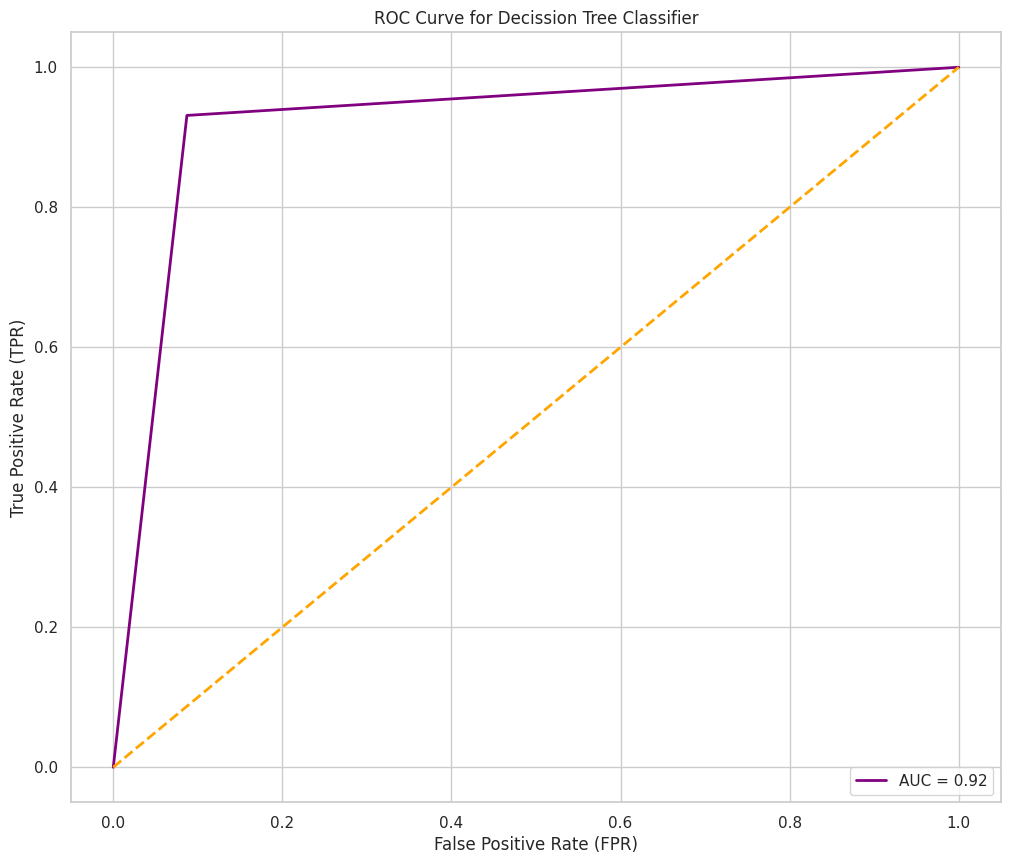

In [ ]:
plt.figure(figsize=(12, 10))
plt.plot(fpr_dtc, tpr_dtc, color='purple', lw=2, label=f'AUC = {auc_value_dtc:.2f}')
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Decission Tree Classifier')
plt.legend(loc='lower right')
plt.show()

# **Decoding the URL**

In [ ]:
pip install python-whois

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 2.4 MB/s eta 0:00:00


In [ ]:
pip install python-googlesearch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 7.4 MB/s eta 0:00:00


In [ ]:
import ipaddress
import re
import urllib.request
from bs4 import BeautifulSoup
import socket
import requests
import google
import whois
from datetime import date, datetime
import time
from dateutil.parser import parse as date_parse
from urllib.parse import urlparse

class FeatureExtraction:
    features = []
    def __init__(self,url):
        self.features = []
        self.url = url
        self.domain = ""
        self.whois_response = ""
        self.urlparse = ""
        self.response = ""
        self.soup = ""

        try:
            self.response = requests.get(url)
            self.soup = BeautifulSoup(response.text, 'html.parser')
        except:
            pass

        try:
            self.urlparse = urlparse(url)
            self.domain = self.urlparse.netloc
        except:
            pass

        try:
            self.whois_response = whois.whois(self.domain)
        except:
            pass

        self.features.append(self.UsingIp())
        self.features.append(self.longUrl())
        self.features.append(self.shortUrl())
        self.features.append(self.symbol())
        self.features.append(self.redirecting())
        self.features.append(self.prefixSuffix())
        self.features.append(self.SubDomains())
        self.features.append(self.Hppts())
        self.features.append(self.DomainRegLen())
        self.features.append(self.Favicon())

        self.features.append(self.NonStdPort())
        self.features.append(self.HTTPSDomainURL())
        self.features.append(self.RequestURL())
        self.features.append(self.AnchorURL())
        self.features.append(self.LinksInScriptTags())
        self.features.append(self.ServerFormHandler())
        self.features.append(self.InfoEmail())
        self.features.append(self.AbnormalURL())
        self.features.append(self.WebsiteForwarding())
        self.features.append(self.StatusBarCust())

        self.features.append(self.DisableRightClick())
        self.features.append(self.UsingPopupWindow())
        self.features.append(self.IframeRedirection())
        self.features.append(self.AgeofDomain())
        self.features.append(self.DNSRecording())
        self.features.append(self.WebsiteTraffic())
        self.features.append(self.PageRank())
        self.features.append(self.GoogleIndex())
        self.features.append(self.LinksPointingToPage())
        self.features.append(self.StatsReport())

     # 1.UsingIp
    def UsingIp(self):
        try:
            ipaddress.ip_address(self.url)
            return -1
        except:
            return 1

    # 2.longUrl
    def longUrl(self):
        if len(self.url) < 54:
            return 1
        if len(self.url) >= 54 and len(self.url) <= 75:
            return 0
        return -1

    # 3.shortUrl
    def shortUrl(self):
        match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                    'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                    'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                    'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                    'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                    'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                    'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|tr\.im|link\.zip\.net', self.url)
        if match:
            return -1
        return 1

    # 4.Symbol@
    def symbol(self):
        if re.findall("@",self.url):
            return -1
        return 1

    # 5.Redirecting//
    def redirecting(self):
        if self.url.rfind('//')>6:
            return -1
        return 1

    # 6.prefixSuffix
    def prefixSuffix(self):
        try:
            match = re.findall('\-', self.domain)
            if match:
                return -1
            return 1
        except:
            return -1

    # 7.SubDomains
    def SubDomains(self):
        dot_count = len(re.findall("\.", self.url))
        if dot_count == 1:
            return 1
        elif dot_count == 2:
            return 0
        return -1

    # 8.HTTPS
    def Hppts(self):
        try:
            https = self.urlparse.scheme
            if 'https' in https:
                return 1
            return -1
        except:
            return 1

    # 9.DomainRegLen
    def DomainRegLen(self):
        try:
            expiration_date = self.whois_response.expiration_date
            creation_date = self.whois_response.creation_date
            try:
                if(len(expiration_date)):
                    expiration_date = expiration_date[0]
            except:
                pass
            try:
                if(len(creation_date)):
                    creation_date = creation_date[0]
            except:
                pass

            age = (expiration_date.year-creation_date.year)*12+ (expiration_date.month-creation_date.month)
            if age >=12:
                return 1
            return -1
        except:
            return -1

    # 10. Favicon
    def Favicon(self):
        try:
            for head in self.soup.find_all('head'):
                for head.link in self.soup.find_all('link', href=True):
                    dots = [x.start(0) for x in re.finditer('\.', head.link['href'])]
                    if self.url in head.link['href'] or len(dots) == 1 or domain in head.link['href']:
                        return 1
            return -1
        except:
            return -1

    # 11. NonStdPort
    def NonStdPort(self):
        try:
            port = self.domain.split(":")
            if len(port)>1:
                return -1
            return 1
        except:
            return -1

    # 12. HTTPSDomainURL
    def HTTPSDomainURL(self):
        try:
            if 'https' in self.domain:
                return -1
            return 1
        except:
            return -1

    # 13. RequestURL
    def RequestURL(self):
        try:
            for img in self.soup.find_all('img', src=True):
                dots = [x.start(0) for x in re.finditer('\.', img['src'])]
                if self.url in img['src'] or self.domain in img['src'] or len(dots) == 1:
                    success = success + 1
                i = i+1

            for audio in self.soup.find_all('audio', src=True):
                dots = [x.start(0) for x in re.finditer('\.', audio['src'])]
                if self.url in audio['src'] or self.domain in audio['src'] or len(dots) == 1:
                    success = success + 1
                i = i+1

            for embed in self.soup.find_all('embed', src=True):
                dots = [x.start(0) for x in re.finditer('\.', embed['src'])]
                if self.url in embed['src'] or self.domain in embed['src'] or len(dots) == 1:
                    success = success + 1
                i = i+1

            for iframe in self.soup.find_all('iframe', src=True):
                dots = [x.start(0) for x in re.finditer('\.', iframe['src'])]
                if self.url in iframe['src'] or self.domain in iframe['src'] or len(dots) == 1:
                    success = success + 1
                i = i+1

            try:
                percentage = success/float(i) * 100
                if percentage < 22.0:
                    return 1
                elif((percentage >= 22.0) and (percentage < 61.0)):
                    return 0
                else:
                    return -1
            except:
                return 0
        except:
            return -1

    # 14. AnchorURL
    def AnchorURL(self):
        try:
            i,unsafe = 0,0
            for a in self.soup.find_all('a', href=True):
                if "#" in a['href'] or "javascript" in a['href'].lower() or "mailto" in a['href'].lower() or not (url in a['href'] or self.domain in a['href']):
                    unsafe = unsafe + 1
                i = i + 1

            try:
                percentage = unsafe / float(i) * 100
                if percentage < 31.0:
                    return 1
                elif ((percentage >= 31.0) and (percentage < 67.0)):
                    return 0
                else:
                    return -1
            except:
                return -1

        except:
            return -1

    # 15. LinksInScriptTags
    def LinksInScriptTags(self):
        try:
            i,success = 0,0

            for link in self.soup.find_all('link', href=True):
                dots = [x.start(0) for x in re.finditer('\.', link['href'])]
                if self.url in link['href'] or self.domain in link['href'] or len(dots) == 1:
                    success = success + 1
                i = i+1

            for script in self.soup.find_all('script', src=True):
                dots = [x.start(0) for x in re.finditer('\.', script['src'])]
                if self.url in script['src'] or self.domain in script['src'] or len(dots) == 1:
                    success = success + 1
                i = i+1

            try:
                percentage = success / float(i) * 100
                if percentage < 17.0:
                    return 1
                elif((percentage >= 17.0) and (percentage < 81.0)):
                    return 0
                else:
                    return -1
            except:
                return 0
        except:
            return -1

    # 16. ServerFormHandler
    def ServerFormHandler(self):
        try:
            if len(self.soup.find_all('form', action=True))==0:
                return 1
            else :
                for form in self.soup.find_all('form', action=True):
                    if form['action'] == "" or form['action'] == "about:blank":
                        return -1
                    elif self.url not in form['action'] and self.domain not in form['action']:
                        return 0
                    else:
                        return 1
        except:
            return -1

    # 17. InfoEmail
    def InfoEmail(self):
        try:
            if re.findall(r"[mail\(\)|mailto:?]", self.soap):
                return -1
            else:
                return 1
        except:
            return -1

    # 18. AbnormalURL
    def AbnormalURL(self):
        try:
            if self.response.text == self.whois_response:
                return 1
            else:
                return -1
        except:
            return -1

    # 19. WebsiteForwarding
    def WebsiteForwarding(self):
        try:
            if len(self.response.history) <= 1:
                return 1
            elif len(self.response.history) <= 4:
                return 0
            else:
                return -1
        except:
             return -1

    # 20. StatusBarCust
    def StatusBarCust(self):
        try:
            if re.findall("<script>.+onmouseover.+</script>", self.response.text):
                return 1
            else:
                return -1
        except:
             return -1

    # 21. DisableRightClick
    def DisableRightClick(self):
        try:
            if re.findall(r"event.button ?== ?2", self.response.text):
                return 1
            else:
                return -1
        except:
             return -1

    # 22. UsingPopupWindow
    def UsingPopupWindow(self):
        try:
            if re.findall(r"alert\(", self.response.text):
                return 1
            else:
                return -1
        except:
             return -1

    # 23. IframeRedirection
    def IframeRedirection(self):
        try:
            if re.findall(r"[<iframe>|<frameBorder>]", self.response.text):
                return 1
            else:
                return -1
        except:
             return -1

    # 24. AgeofDomain
    def AgeofDomain(self):
        try:
            creation_date = self.whois_response.creation_date
            try:
                if(len(creation_date)):
                    creation_date = creation_date[0]
            except:
                pass

            today  = date.today()
            age = (today.year-creation_date.year)*12+(today.month-creation_date.month)
            if age >=6:
                return 1
            return -1
        except:
            return -1

    # 25. DNSRecording
    def DNSRecording(self):
        try:
            creation_date = self.whois_response.creation_date
            try:
                if(len(creation_date)):
                    creation_date = creation_date[0]
            except:
                pass

            today  = date.today()
            age = (today.year-creation_date.year)*12+(today.month-creation_date.month)
            if age >=6:
                return 1
            return -1
        except:
            return -1

    # 26. WebsiteTraffic
    def WebsiteTraffic(self):
        try:
            rank = BeautifulSoup(urllib.request.urlopen("http://data.alexa.com/data?cli=10&dat=s&url=" + url).read(), "xml").find("REACH")['RANK']
            if (int(rank) < 100000):
                return 1
            return 0
        except :
            return -1

    # 27. PageRank
    def PageRank(self):
        try:
            prank_checker_response = requests.post("https://www.checkpagerank.net/index.php", {"name": self.domain})

            global_rank = int(re.findall(r"Global Rank: ([0-9]+)", rank_checker_response.text)[0])
            if global_rank > 0 and global_rank < 100000:
                return 1
            return -1
        except:
            return -1


    # 28. GoogleIndex
    def GoogleIndex(self):
        try:
            site = search(self.url, 5)
            if site:
                return 1
            else:
                return -1
        except:
            return 1

    # 29. LinksPointingToPage
    def LinksPointingToPage(self):
        try:
            number_of_links = len(re.findall(r"<a href=", self.response.text))
            if number_of_links == 0:
                return 1
            elif number_of_links <= 2:
                return 0
            else:
                return -1
        except:
            return -1

    # 30. StatsReport
    def StatsReport(self):
        try:
            url_match = re.search(
        'at\.ua|usa\.cc|baltazarpresentes\.com\.br|pe\.hu|esy\.es|hol\.es|sweddy\.com|myjino\.ru|96\.lt|ow\.ly', url)
            ip_address = socket.gethostbyname(self.domain)
            ip_match = re.search('146\.112\.61\.108|213\.174\.157\.151|121\.50\.168\.88|192\.185\.217\.116|78\.46\.211\.158|181\.174\.165\.13|46\.242\.145\.103|121\.50\.168\.40|83\.125\.22\.219|46\.242\.145\.98|'
                                '107\.151\.148\.44|107\.151\.148\.107|64\.70\.19\.203|199\.184\.144\.27|107\.151\.148\.108|107\.151\.148\.109|119\.28\.52\.61|54\.83\.43\.69|52\.69\.166\.231|216\.58\.192\.225|'
                                '118\.184\.25\.86|67\.208\.74\.71|23\.253\.126\.58|104\.239\.157\.210|175\.126\.123\.219|141\.8\.224\.221|10\.10\.10\.10|43\.229\.108\.32|103\.232\.215\.140|69\.172\.201\.153|'
                                '216\.218\.185\.162|54\.225\.104\.146|103\.243\.24\.98|199\.59\.243\.120|31\.170\.160\.61|213\.19\.128\.77|62\.113\.226\.131|208\.100\.26\.234|195\.16\.127\.102|195\.16\.127\.157|'
                                '34\.196\.13\.28|103\.224\.212\.222|172\.217\.4\.225|54\.72\.9\.51|192\.64\.147\.141|198\.200\.56\.183|23\.253\.164\.103|52\.48\.191\.26|52\.214\.197\.72|87\.98\.255\.18|209\.99\.17\.27|'
                                '216\.38\.62\.18|104\.130\.124\.96|47\.89\.58\.141|78\.46\.211\.158|54\.86\.225\.156|54\.82\.156\.19|37\.157\.192\.102|204\.11\.56\.48|110\.34\.231\.42', ip_address)
            if url_match:
                return -1
            elif ip_match:
                return -1
            return 1
        except:
            return 1

    def getFeaturesList(self):
        return self.features

In [ ]:
gbc = GradientBoostingClassifier(max_depth=4,learning_rate=0.7)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.7, max_depth=4)

# **Final Testing**

In [ ]:
url="https://appleid.apple.com-sa.pm/appleid/?"
obj = FeatureExtraction(url)
x = np.array(obj.getFeaturesList()).reshape(1,30)
y_pred =gbc.predict(x)[0]
if y_pred==1:
  print("Prediction: Safe website.")
else:
    print("Warning: Potentially malicious website detected.")

In [ ]:
url="https://www.google.com/"
obj = FeatureExtraction(url)
x = np.array(obj.getFeaturesList()).reshape(1,30)
y_pred =gbc.predict(x)[0]
if y_pred==1:
  print("Prediction: Safe website.")
else:
    print("Warning: Potentially malicious website detected.")

Prediction: Safe website.


# **Conclusion**
In this project, we developed and evaluated multiple machine learning models to detect phishing websites based on URL features. After rigorous experimentation with algorithms such as K-Nearest Neighbors (KNN), Support Vector Machine (SVM), and Gradient Boosting, the Gradient Boost classifier demonstrated the highest accuracy and overall performance across evaluation metrics including F1-score, AUC, precision, and recall.

The model's ability to generalize well on unseen data suggests it can be effectively used to identify malicious URLs in real-world scenarios. Feature selection techniques were also explored to optimize model performance and reduce overfitting.

This work lays a foundation for deploying an intelligent, automated phishing detection system, enhancing user safety and supporting cybersecurity efforts. Future improvements can include integrating real-time URL scraping, using deep learning techniques, and expanding the feature set with contextual and content-based data.